## with distinct 

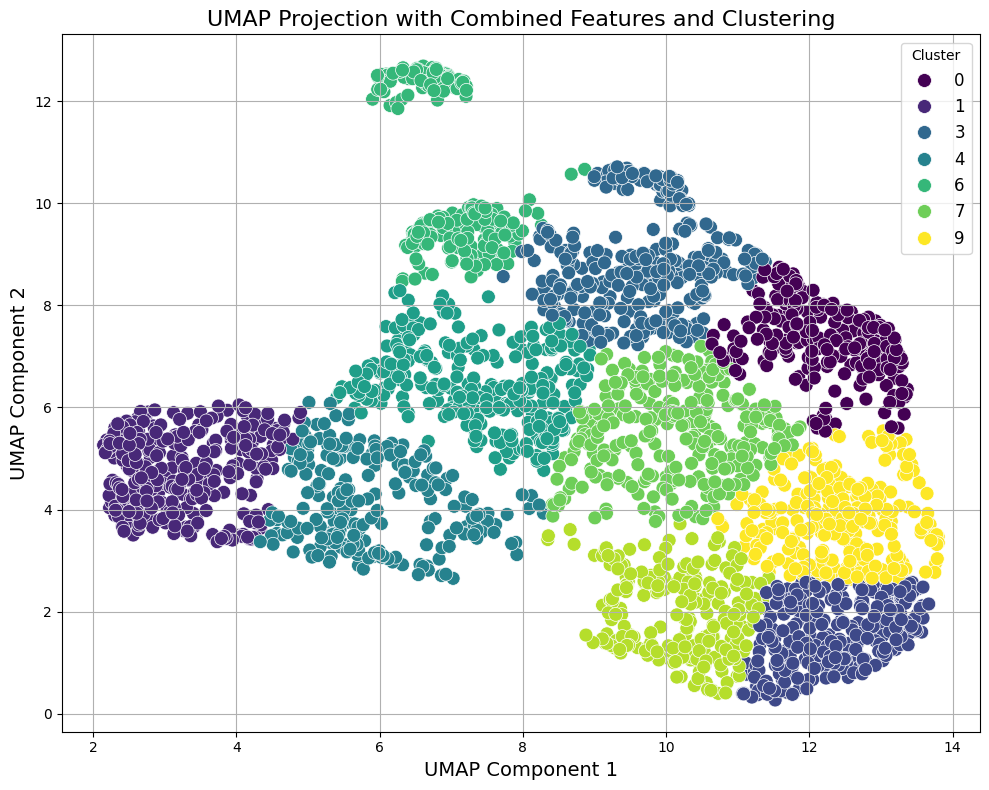

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from umap import UMAP
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import cosine_similarity
import gseapy as gp
import pickle

# Load proteomics data
proteomics_metadata = pd.read_csv('AML_proteomics_meta.txt', sep='\t')
quant = pd.read_csv('AML_proteomics_quant.txt', sep='\t', index_col=0)
log2fc_df = pd.read_csv('DEqMS_LC_log2FC_all.txt', sep='\t', index_col=0)
pval_df = pd.read_csv('DEqMS_LC_Pvalues_all.txt', sep='\t', index_col=0)

# Filter proteins based on fold change and p-value thresholds
fc_value = 0.5
p_value = 0.01
fc_thres = log2fc_df[log2fc_df.abs() > fc_value].dropna(how='all')
p_thres = pval_df[pval_df < p_value].dropna(how='all')
distinct_proteins = set(fc_thres.index) & set(p_thres.index)

# Filter the quant matrix for distinct proteins
quant_filtered = quant.loc[list(distinct_proteins)]

# Compute correlation matrix for filtered proteins
correlation_matrix = quant_filtered.T.corr(method='pearson')

# Load GenePT gene embeddings
with open('GenePT_emebdding_v2/GenePT_gene_embedding_ada_text.pickle', 'rb') as f:
    gene_embeddings_ada = pickle.load(f)

with open('GenePT_emebdding_v2/GenePT_gene_protein_embedding_model_3_text.pickle.', 'rb') as f:
    gene_embeddings_protein = pickle.load(f)

# Filter GenePT embeddings for distinct proteins
filtered_embeddings = {gene: emb for gene, emb in gene_embeddings_protein.items() if gene in distinct_proteins}

# Convert filtered embeddings to a DataFrame
embedding_df = pd.DataFrame.from_dict(filtered_embeddings, orient='index')

# Compute cosine similarity matrix for GenePT embeddings
genept_similarity_matrix = cosine_similarity(embedding_df)

# Ensure matrices are aligned by index (proteins)
common_proteins = sorted(set(quant_filtered.index) & set(embedding_df.index))

quant_filtered = quant_filtered.loc[common_proteins]
correlation_matrix = correlation_matrix.loc[common_proteins, common_proteins]
embedding_df = embedding_df.loc[common_proteins]

# Combine both similarity matrix (from quant data) and GenePT embeddings as features
combined_features = np.hstack([correlation_matrix.values, embedding_df.values])

# Dimensionality reduction using PCA
pca = PCA(n_components=50)
pca_result = pca.fit_transform(combined_features)

# Further reduction using UMAP
umap_model = UMAP(n_neighbors=20, min_dist=0.2, metric='euclidean')
umap_result = umap_model.fit_transform(pca_result)

# Clustering using K-Means
kmeans = KMeans(n_clusters=10, random_state=42)
clusters = kmeans.fit_predict(umap_result)

# Create a DataFrame for UMAP results and cluster assignments
umap_df = pd.DataFrame(umap_result, columns=['UMAP1', 'UMAP2'])
umap_df['Cluster'] = clusters
umap_df['Protein'] = common_proteins

# Visualization: UMAP with K-Means clusters
plt.figure(figsize=(10, 8))
sns.scatterplot(data=umap_df, x='UMAP1', y='UMAP2', hue='Cluster', palette='viridis', s=100, edgecolor='w', linewidth=0.5)
plt.title('UMAP Projection with Combined Features and Clustering', fontsize=16)
plt.xlabel('UMAP Component 1', fontsize=14)
plt.ylabel('UMAP Component 2', fontsize=14)
plt.legend(title='Cluster', fontsize=12)
plt.grid(True)
plt.tight_layout()
plt.show()



In [3]:
import pandas as pd
import numpy as np
import itertools
from sklearn.model_selection import train_test_split

# Load proteomics data (assuming this is already done in your workflow)
proteomics_metadata = pd.read_csv('AML_proteomics_meta.txt', sep='\t')
quant = pd.read_csv('AML_proteomics_quant.txt', sep='\t', index_col=0)
log2fc_df = pd.read_csv('DEqMS_LC_log2FC_all.txt', sep='\t', index_col=0)
pval_df = pd.read_csv('DEqMS_LC_Pvalues_all.txt', sep='\t', index_col=0)

# Filter proteins based on fold change and p-value thresholds
fc_value = 0.5
p_value = 0.01
fc_thres = log2fc_df[log2fc_df.abs() > fc_value].dropna(how='all')
p_thres = pval_df[pval_df < p_value].dropna(how='all')
distinct_proteins = set(fc_thres.index) & set(p_thres.index)

# Filter the quant matrix for distinct proteins
quant_filtered = quant.loc[list(distinct_proteins)]

# Load CORUM data
corum = pd.read_csv('CORUM_dat.txt', sep='\t')  # Adjust the separator as per the actual file

def extract_ppi_from_corum(corum_df, gene_col='subunits.Gene.name.'):
    ppi_pairs = set()
    for proteins in corum_df[gene_col].dropna():
        proteins = proteins.split(';')  # Assuming proteins are separated by semicolons
        proteins = [prot.strip() for prot in proteins]
        for pair in itertools.combinations(proteins, 2):
            ppi_pairs.add(pair)
    return ppi_pairs

# Now call the function with the updated column name
known_ppi = extract_ppi_from_corum(corum)

# Ensure proteins in CORUM are in the quant_filtered dataset
known_ppi = {pair for pair in known_ppi if pair[0] in quant_filtered.index and pair[1] in quant_filtered.index}

print(f"Number of known PPIs: {len(known_ppi)}")

Number of known PPIs: 668


In [4]:
# Total possible pairs
all_proteins = list(quant_filtered.index)
total_possible_pairs = set(itertools.combinations(sorted(all_proteins), 2))

# Exclude known PPIs to get negative candidates
non_interacting_pairs = list(total_possible_pairs - known_ppi)

# Number of negative samples (e.g., equal to positives)
num_negatives = len(known_ppi)

# Randomly select negative samples
np.random.seed(42)
negative_samples = set()
while len(negative_samples) < num_negatives:
    pair = tuple(np.random.choice(all_proteins, 2, replace=False))
    pair = tuple(sorted(pair))
    if pair not in known_ppi and pair not in negative_samples:
        negative_samples.add(pair)

print(f"Number of negative samples: {len(negative_samples)}")

Number of negative samples: 668


In [5]:
# Create DataFrame for positive and negative samples
positive_df = pd.DataFrame(list(known_ppi), columns=['Protein1', 'Protein2'])
positive_df['Label'] = 1

negative_df = pd.DataFrame(list(negative_samples), columns=['Protein1', 'Protein2'])
negative_df['Label'] = 0

# Combine and shuffle
ppi_data = pd.concat([positive_df, negative_df], ignore_index=True)
ppi_data = ppi_data.sample(frac=1, random_state=42).reset_index(drop=True)

print(ppi_data.head())
print(ppi_data['Label'].value_counts())

  Protein1 Protein2  Label
0     APLF    PADI4      0
1  CAPRIN2   RNF220      0
2     IGHD   PM20D2      0
3    ITGB1   COL6A3      1
4    CASP1    NLRP3      1
Label
0    668
1    668
Name: count, dtype: int64


In [6]:
from sklearn.metrics.pairwise import cosine_similarity

# Assuming 'correlation_matrix' and 'embedding_df' are already defined from your initial code

# Function to compute features for each protein pair
# Function to compute features for each protein pair
def compute_features(row, corr_matrix, embedding_df):
    prot1, prot2 = row['Protein1'], row['Protein2']
    
    # Check if both proteins exist in correlation_matrix and embedding_df
    if prot1 not in corr_matrix.index or prot2 not in corr_matrix.columns:
        corr = np.nan  # Assign NaN if protein is missing
    else:
        corr = corr_matrix.loc[prot1, prot2]

    if prot1 not in embedding_df.index or prot2 not in embedding_df.index:
        cos_sim = np.nan
    else:
        # Cosine similarity of embeddings
        emb1 = embedding_df.loc[prot1].values.reshape(1, -1)
        emb2 = embedding_df.loc[prot2].values.reshape(1, -1)
        cos_sim = cosine_similarity(emb1, emb2)[0][0]
    
    if prot1 not in quant_filtered.index or prot2 not in quant_filtered.index:
        euclidean_dist = np.nan
    else:
        # Euclidean distance of quant profiles
        quant1 = quant_filtered.loc[prot1].values
        quant2 = quant_filtered.loc[prot2].values
        euclidean_dist = np.linalg.norm(quant1 - quant2)

    return pd.Series({'Correlation': corr, 'Cosine_Similarity': cos_sim, 'Euclidean_Distance': euclidean_dist})
# Filter PPI data to include only rows where both proteins are present in the correlation_matrix and embedding_df
filtered_ppi_data = ppi_data[
    (ppi_data['Protein1'].isin(correlation_matrix.index)) & 
    (ppi_data['Protein2'].isin(correlation_matrix.columns)) &
    (ppi_data['Protein1'].isin(embedding_df.index)) &
    (ppi_data['Protein2'].isin(embedding_df.index))
]

# Apply feature computation on the filtered data
features = filtered_ppi_data.apply(compute_features, axis=1, args=(correlation_matrix, embedding_df))
feature_df = pd.concat([filtered_ppi_data, features], axis=1)

print(feature_df.head())

  Protein1 Protein2  Label  Correlation  Cosine_Similarity  Euclidean_Distance
0     APLF    PADI4      0    -0.412854           0.493628           10.967397
1  CAPRIN2   RNF220      0    -0.268976           0.506353                 NaN
3    ITGB1   COL6A3      1     0.281054           0.508313           10.344701
4    CASP1    NLRP3      1     0.588414           0.694889            4.065539
5     TJP1     DTNA      1     0.012557           0.488778                 NaN


In [7]:
from sklearn.model_selection import train_test_split

# Features and target
X = feature_df[['Correlation', 'Cosine_Similarity', 'Euclidean_Distance']]
y = feature_df['Label']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Training samples: {X_train.shape[0]}")
print(f"Testing samples: {X_test.shape[0]}")

Training samples: 1026
Testing samples: 257


In [8]:
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Initialize models
rf_model = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')
xgb_model = XGBClassifier(n_estimators=100, use_label_encoder=False, eval_metric='logloss', random_state=42)

# Train Random Forest
rf_model.fit(X_train, y_train)

# Train XGBoost
xgb_model.fit(X_train, y_train)

/Users/justinseby/Library/Python/3.9/lib/python/site-packages/xgboost/core.py:158: UserWarning: [01:25:33] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=100,
              n_jobs=None, num_parallel_tree=None, random_state=42, ...)

--- Random Forest Evaluation ---
Classification Report:
              precision    recall  f1-score   support

           0       0.79      0.89      0.84       131
           1       0.87      0.75      0.81       126

    accuracy                           0.82       257
   macro avg       0.83      0.82      0.82       257
weighted avg       0.83      0.82      0.82       257

ROC-AUC: 0.8767


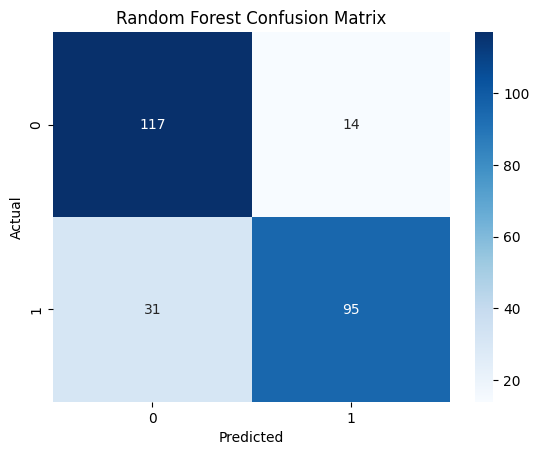

--- XGBoost Evaluation ---
Classification Report:
              precision    recall  f1-score   support

           0       0.77      0.85      0.80       131
           1       0.82      0.73      0.77       126

    accuracy                           0.79       257
   macro avg       0.79      0.79      0.79       257
weighted avg       0.79      0.79      0.79       257

ROC-AUC: 0.8628


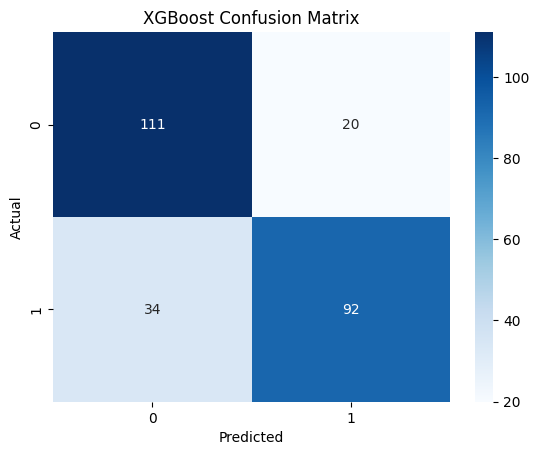

In [9]:
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix

# Function to evaluate models
def evaluate_model(model, X_test, y_test, model_name='Model'):
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]
    
    print(f"--- {model_name} Evaluation ---")
    print("Classification Report:")
    print(classification_report(y_test, y_pred))
    
    roc_auc = roc_auc_score(y_test, y_proba)
    print(f"ROC-AUC: {roc_auc:.4f}")
    
    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'{model_name} Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

# Evaluate Random Forest
evaluate_model(rf_model, X_test, y_test, model_name='Random Forest')

# Evaluate XGBoost
evaluate_model(xgb_model, X_test, y_test, model_name='XGBoost')

Best Parameters for Random Forest: {'max_depth': 10, 'min_samples_split': 5, 'n_estimators': 200}
Best ROC-AUC: 0.8499955261890012
--- Best Random Forest Evaluation ---
Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.90      0.85       131
           1       0.88      0.77      0.82       126

    accuracy                           0.84       257
   macro avg       0.84      0.84      0.84       257
weighted avg       0.84      0.84      0.84       257

ROC-AUC: 0.8871


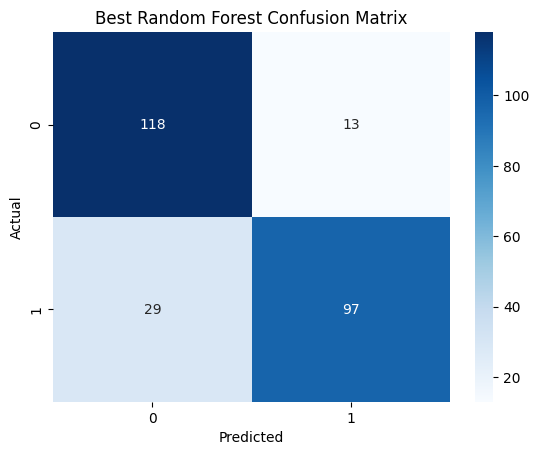

In [10]:
from sklearn.model_selection import GridSearchCV

param_grid_rf = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
}

grid_rf = GridSearchCV(
    estimator=RandomForestClassifier(random_state=42, class_weight='balanced'),
    param_grid=param_grid_rf,
    cv=3,
    scoring='roc_auc',
    n_jobs=-1
)

grid_rf.fit(X_train, y_train)

print("Best Parameters for Random Forest:", grid_rf.best_params_)
print("Best ROC-AUC:", grid_rf.best_score_)

# Best estimator
best_rf = grid_rf.best_estimator_

# Evaluate the best Random Forest
evaluate_model(best_rf, X_test, y_test, model_name='Best Random Forest')

In [11]:
pip install networkx

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: /Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


### Graph creation and analysis

Number of nodes: 470
Number of edges: 628
Average degree: 2.6723404255319148


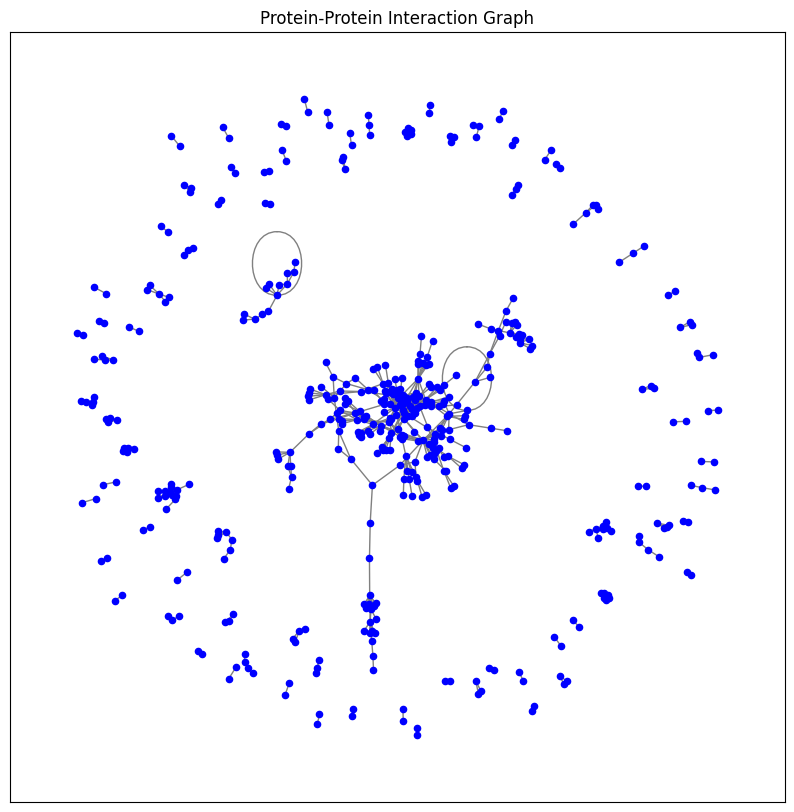

In [12]:
import networkx as nx
import matplotlib.pyplot as plt

# Create a graph
G = nx.Graph()

# Add nodes and edges from the predicted positive interactions
for _, row in feature_df.iterrows():
    if row['Label'] == 1:  # Only include predicted positives (interacting pairs)
        G.add_edge(row['Protein1'], row['Protein2'])

# Basic Graph Information
print("Number of nodes:", G.number_of_nodes())
print("Number of edges:", G.number_of_edges())
print("Average degree:", sum(dict(G.degree()).values()) / G.number_of_nodes())

# Plot the PPI graph
plt.figure(figsize=(10, 10))
pos = nx.spring_layout(G, seed=42)  # Positioning for visualization
nx.draw_networkx(G, pos, node_size=20, node_color='blue', edge_color='gray', with_labels=False)
plt.title("Protein-Protein Interaction Graph")
plt.show()

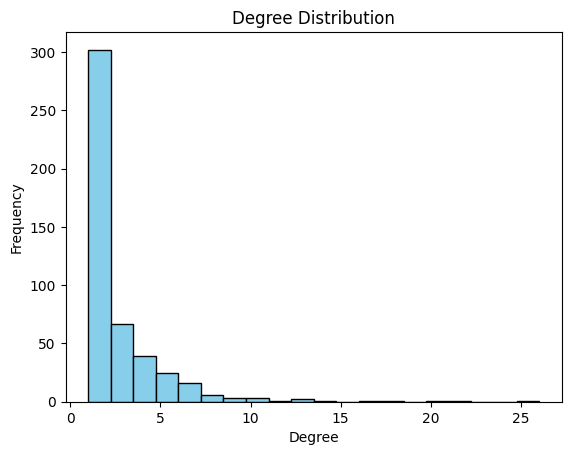

Average Clustering Coefficient: 0.3828
Number of connected components: 83
Largest Component Size: 215
Optional: Install the 'python-louvain' package for community detection.


In [13]:
# Degree distribution
degrees = [G.degree(n) for n in G.nodes()]
plt.hist(degrees, bins=20, color='skyblue', edgecolor='black')
plt.title("Degree Distribution")
plt.xlabel("Degree")
plt.ylabel("Frequency")
plt.show()

# Clustering Coefficient
clustering_coeff = nx.average_clustering(G)
print(f"Average Clustering Coefficient: {clustering_coeff:.4f}")

# Connected Components
components = [G.subgraph(c).copy() for c in nx.connected_components(G)]
print(f"Number of connected components: {len(components)}")

# Largest Component Analysis
largest_component = max(components, key=len)
print(f"Largest Component Size: {largest_component.number_of_nodes()}")

# Community Detection (optional - using Louvain or similar algorithms)
try:
    from community import community_louvain
    partition = community_louvain.best_partition(G)
    # Visualize communities (optional)
    pos = nx.spring_layout(G)
    cmap = plt.get_cmap('viridis')
    nx.draw_networkx_nodes(G, pos, node_size=20, cmap=cmap, 
                           node_color=[partition[n] for n in G.nodes()])
    nx.draw_networkx_edges(G, pos, alpha=0.5)
    plt.title("Protein Community Detection")
    plt.show()
except ImportError:
    print("Optional: Install the 'python-louvain' package for community detection.")

In [14]:
pip install networkx python-louvain community

Defaulting to user installation because normal site-packages is not writeable
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Using cached flask-3.0.3-py3-none-any.whl.metadata (3.2 kB)
  Using cached itsdangerous-2.2.0-py3-none-any.whl.metadata (1.9 kB)
  Using cached blinker-1.8.2-py3-none-any.whl.metadata (1.6 kB)
Using cached flask-3.0.3-py3-none-any.whl (101 kB)
Using cached blinker-1.8.2-py3-none-any.whl (9.5 kB)
Using cached itsdangerous-2.2.0-py3-none-any.whl (16 kB)
  Created wheel for python-louvain: filename=python_louvain-0.16-py3-none-any.whl size=9407 sha256=94460c847885a3697215e1bb1bcc9340de5e6feed4dfbb966c38069efce9a027
  Stored in directory: /Users/justinseby/Library/Caches/pip/wheels/4d/7c/b6/79b198e4ec43f915fbdf967953d48b89a18893b12aa9df0ae2
  Created wheel for community: filename=community-1.0.0b1-py3-none-any.whl size=2153 sha256=bc3694a6b9b7ccb31c401f67dbe255cf60cf78b1a69e3cceb64d95422e0659e0
  Stored in directory: /Users/justin

In [16]:
import networkx as nx
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from community import community_louvain
from collections import defaultdict
import seaborn as sns

def construct_ppi_network(feature_df, model, confidence_threshold=0.7):
    """
    Construct PPI network based on model predictions with confidence threshold
    """
    # Reset index to ensure alignment
    feature_df = feature_df.reset_index(drop=True)
    
    # Get prediction probabilities
    probs = model.predict_proba(feature_df[['Correlation', 'Cosine_Similarity', 'Euclidean_Distance']])
    
    # Create network
    G = nx.Graph()
    
    # Add edges with high confidence predictions
    for idx, (prob, row) in enumerate(zip(probs, feature_df.itertuples())):
        if prob[1] >= confidence_threshold:
            G.add_edge(row.Protein1, row.Protein2, 
                      weight=prob[1],
                      correlation=row.Correlation,
                      cosine_sim=row.Cosine_Similarity)
    
    print(f"Network construction complete: {G.number_of_nodes()} nodes and {G.number_of_edges()} edges")
    return G

def analyze_network(G):
    """
    Perform network analysis and return key metrics
    """
    metrics = {}
    
    # Basic network statistics
    metrics['num_nodes'] = G.number_of_nodes()
    metrics['num_edges'] = G.number_of_edges()
    metrics['density'] = nx.density(G)
    
    # Degree distribution
    degrees = dict(G.degree())
    metrics['avg_degree'] = sum(degrees.values()) / len(degrees) if degrees else 0
    metrics['max_degree'] = max(degrees.values()) if degrees else 0
    
    # Centrality measures (with error handling)
    try:
        degree_cent = nx.degree_centrality(G)
        betweenness_cent = nx.betweenness_centrality(G)
        metrics['top_degree_nodes'] = sorted(degree_cent.items(), key=lambda x: x[1], reverse=True)[:10]
        metrics['top_betweenness_nodes'] = sorted(betweenness_cent.items(), key=lambda x: x[1], reverse=True)[:10]
    except Exception as e:
        print(f"Warning: Could not compute centrality measures: {str(e)}")
        metrics['top_degree_nodes'] = []
        metrics['top_betweenness_nodes'] = []
    
    # Community detection (with error handling)
    try:
        communities = community_louvain.best_partition(G)
        metrics['num_communities'] = len(set(communities.values()))
        metrics['communities'] = communities
    except Exception as e:
        print(f"Warning: Could not detect communities: {str(e)}")
        metrics['num_communities'] = 0
        metrics['communities'] = {node: 0 for node in G.nodes()}
    
    return metrics

def visualize_network(G, metrics, output_prefix="network"):
    """
    Create network visualizations with error handling
    """
    if G.number_of_nodes() == 0:
        print("Warning: Empty network, skipping visualization")
        return
        
    try:
        # Set up the figure
        plt.figure(figsize=(15, 15))
        
        # Node positions
        pos = nx.spring_layout(G, k=1/np.sqrt(len(G.nodes())), iterations=50)
        
        # Node colors based on communities
        communities = metrics['communities']
        colors = [communities[node] for node in G.nodes()]
        
        # Node sizes based on degree centrality
        node_sizes = [v * 3000 for v in nx.degree_centrality(G).values()]
        
        # Draw the network
        nx.draw_networkx_nodes(G, pos, node_color=colors, node_size=node_sizes, alpha=0.7)
        nx.draw_networkx_edges(G, pos, alpha=0.2)
        nx.draw_networkx_labels(G, pos, font_size=8)
        
        plt.title("Protein-Protein Interaction Network\nColored by Communities, Size by Degree Centrality")
        plt.axis('off')
        plt.tight_layout()
        plt.savefig(f"{output_prefix}_visualization.png", dpi=300, bbox_inches='tight')
        plt.close()
        
        # Degree distribution
        plt.figure(figsize=(10, 6))
        degrees = [d for n, d in G.degree()]
        plt.hist(degrees, bins=30, alpha=0.75)
        plt.xlabel("Degree")
        plt.ylabel("Frequency")
        plt.title("Degree Distribution")
        plt.savefig(f"{output_prefix}_degree_dist.png", dpi=300, bbox_inches='tight')
        plt.close()
        
    except Exception as e:
        print(f"Warning: Error in network visualization: {str(e)}")

def print_network_stats(metrics):
    """
    Print network statistics in a formatted way
    """
    print("\n=== Network Statistics ===")
    print(f"Number of nodes: {metrics['num_nodes']}")
    print(f"Number of edges: {metrics['num_edges']}")
    print(f"Network density: {metrics['density']:.4f}")
    print(f"Average degree: {metrics['avg_degree']:.2f}")
    print(f"Number of communities: {metrics['num_communities']}")
    
    if metrics['top_degree_nodes']:
        print("\n=== Top Hub Proteins (Degree Centrality) ===")
        for node, cent in metrics['top_degree_nodes'][:5]:
            print(f"{node}: {cent:.4f}")
    
    if metrics['top_betweenness_nodes']:
        print("\n=== Top Bottleneck Proteins (Betweenness Centrality) ===")
        for node, cent in metrics['top_betweenness_nodes'][:5]:
            print(f"{node}: {cent:.4f}")

def analyze_communities(G, metrics):
    """
    Analyze protein communities for functional patterns
    """
    if metrics['num_communities'] == 0:
        print("No communities detected for analysis")
        return
        
    communities = metrics['communities']
    community_members = defaultdict(list)
    
    # Group proteins by community
    for protein, comm_id in communities.items():
        community_members[comm_id].append(protein)
    
    # Print community statistics
    print("\n=== Community Analysis ===")
    for comm_id, members in community_members.items():
        print(f"\nCommunity {comm_id}")
        print(f"Size: {len(members)}")
        print(f"Sample members: {', '.join(members[:5])}")
        
        # Calculate internal density
        subgraph = G.subgraph(members)
        density = nx.density(subgraph)
        print(f"Internal density: {density:.4f}")

# Now let's run the analysis with debug information
print("Starting network construction...")
print(f"Feature DataFrame shape: {feature_df.shape}")
print(f"Number of features used: {len(['Correlation', 'Cosine_Similarity', 'Euclidean_Distance'])}")

# Construct and analyze the network
G = construct_ppi_network(feature_df, best_rf, confidence_threshold=0.7)
metrics = analyze_network(G)

# Visualize the network
visualize_network(G, metrics)
print_network_stats(metrics)

# Run community analysis
analyze_communities(G, metrics)

Starting network construction...
Feature DataFrame shape: (1283, 6)
Number of features used: 3
Network construction complete: 393 nodes and 447 edges

=== Network Statistics ===
Number of nodes: 393
Number of edges: 447
Network density: 0.0058
Average degree: 2.27
Number of communities: 93

=== Top Hub Proteins (Degree Centrality) ===
ITGB1: 0.0561
ITGB3: 0.0459
ITGAV: 0.0332
PTK2: 0.0306
ITGA2B: 0.0255

=== Top Bottleneck Proteins (Betweenness Centrality) ===
ITGB3: 0.0300
ITGB1: 0.0209
PTK2: 0.0192
LCK: 0.0152
PTK2B: 0.0143

=== Community Analysis ===

Community 0
Size: 25
Sample members: ITGB1, COL6A3, VCAM1, CD81, ADGRG1
Internal density: 0.1200

Community 1
Size: 13
Sample members: CASP1, NLRP3, MEFV, RIPK3, NLRC4
Internal density: 0.2821

Community 2
Size: 39
Sample members: AGT, C3, PLAUR, MRC2, ACTN1
Internal density: 0.0918

Community 3
Size: 7
Sample members: AURKA, TPX2, BIRC5, CDCA8, INCENP
Internal density: 0.5238

Community 4
Size: 2
Sample members: PLXNB1, SEMA4D
Interna

In [18]:
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from matplotlib.colors import LinearSegmentedColormap

def create_ppi_network(feature_df, model, confidence_threshold=0.7):
    """
    Create PPI network from classifier predictions
    """
    # Reset index and get predictions
    feature_df = feature_df.reset_index(drop=True)
    probs = model.predict_proba(feature_df[['Correlation', 'Cosine_Similarity', 'Euclidean_Distance']])
    
    # Create network
    G = nx.Graph()
    
    # Add edges for high-confidence predictions
    edges_added = 0
    for (_, row), prob in zip(feature_df.iterrows(), probs):
        if prob[1] >= confidence_threshold:
            G.add_edge(row['Protein1'], row['Protein2'], 
                      weight=prob[1],
                      correlation=row['Correlation'])
            edges_added += 1
            
    print(f"Network created with {G.number_of_nodes()} nodes and {edges_added} edges")
    return G

def visualize_ppi_network(G, output_prefix="ppi_network", layout_type="spring"):
    """
    Create multiple visualizations of the PPI network
    """
    # Create custom colormap from white to dark blue
    colors = ['#ffffff', '#deebf7', '#9ecae1', '#4292c6', '#084594']
    cm = LinearSegmentedColormap.from_list('custom_blue', colors)
    
    # Calculate node properties
    degree_cent = nx.degree_centrality(G)
    betweenness_cent = nx.betweenness_centrality(G)
    
    # Set up layout
    if layout_type == "spring":
        pos = nx.spring_layout(G, k=1/np.sqrt(len(G.nodes())), iterations=50)
    elif layout_type == "kamada_kawai":
        pos = nx.kamada_kawai_layout(G)
    else:
        pos = nx.circular_layout(G)
    
    # Create visualizations
    
    # 1. Degree Centrality Visualization
    plt.figure(figsize=(15, 15))
    node_sizes = [v * 5000 for v in degree_cent.values()]
    edge_weights = [G[u][v].get('weight', 0.5) for u, v in G.edges()]
    
    nx.draw_networkx_edges(G, pos, alpha=0.2, width=1)
    nodes = nx.draw_networkx_nodes(G, pos, 
                                 node_size=node_sizes,
                                 node_color=list(degree_cent.values()),
                                 cmap=cm,
                                 alpha=0.7)
    nx.draw_networkx_labels(G, pos, font_size=8)
    
    plt.colorbar(nodes, label='Degree Centrality')
    plt.title("PPI Network - Node Size and Color by Degree Centrality")
    plt.axis('off')
    plt.tight_layout()
    plt.savefig(f"{output_prefix}_degree_centrality.png", dpi=300, bbox_inches='tight')
    plt.close()
    
    # 2. Betweenness Centrality Visualization
    plt.figure(figsize=(15, 15))
    node_sizes = [v * 5000 for v in betweenness_cent.values()]
    
    nx.draw_networkx_edges(G, pos, alpha=0.2, width=1)
    nodes = nx.draw_networkx_nodes(G, pos, 
                                 node_size=node_sizes,
                                 node_color=list(betweenness_cent.values()),
                                 cmap=cm,
                                 alpha=0.7)
    nx.draw_networkx_labels(G, pos, font_size=8)
    
    plt.colorbar(nodes, label='Betweenness Centrality')
    plt.title("PPI Network - Node Size and Color by Betweenness Centrality")
    plt.axis('off')
    plt.tight_layout()
    plt.savefig(f"{output_prefix}_betweenness_centrality.png", dpi=300, bbox_inches='tight')
    plt.close()
    
    # 3. Network Statistics
    plt.figure(figsize=(12, 6))
    degrees = [d for n, d in G.degree()]
    plt.hist(degrees, bins=30, alpha=0.75, color='#4292c6')
    plt.xlabel("Degree")
    plt.ylabel("Frequency")
    plt.title("Degree Distribution")
    plt.savefig(f"{output_prefix}_degree_distribution.png", dpi=300, bbox_inches='tight')
    plt.close()
    
    # Return network metrics
    return {
        'nodes': G.number_of_nodes(),
        'edges': G.number_of_edges(),
        'density': nx.density(G),
        'avg_degree': np.mean(degrees),
        'max_degree': max(degrees),
        'top_degree_nodes': sorted(degree_cent.items(), key=lambda x: x[1], reverse=True)[:10],
        'top_betweenness_nodes': sorted(betweenness_cent.items(), key=lambda x: x[1], reverse=True)[:10]
    }

# Create and visualize the network
# First with spring layout
G = create_ppi_network(feature_df, best_rf, confidence_threshold=0.7)
metrics_spring = visualize_ppi_network(G, output_prefix="ppi_network_spring", layout_type="spring")

# Then with Kamada-Kawai layout for comparison
metrics_kk = visualize_ppi_network(G, output_prefix="ppi_network_kk", layout_type="kamada_kawai")

# Print network statistics
print("\nNetwork Statistics:")
print(f"Number of nodes: {metrics_spring['nodes']}")
print(f"Number of edges: {metrics_spring['edges']}")
print(f"Network density: {metrics_spring['density']:.4f}")
print(f"Average degree: {metrics_spring['avg_degree']:.2f}")
print(f"Maximum degree: {metrics_spring['max_degree']}")

print("\nTop 5 Hub Proteins (Highest Degree):")
for node, cent in metrics_spring['top_degree_nodes'][:5]:
    print(f"{node}: {cent:.4f}")

print("\nTop 5 Bottleneck Proteins (Highest Betweenness):")
for node, cent in metrics_spring['top_betweenness_nodes'][:5]:
    print(f"{node}: {cent:.4f}")

Network created with 393 nodes and 447 edges

Network Statistics:
Number of nodes: 393
Number of edges: 447
Network density: 0.0058
Average degree: 2.27
Maximum degree: 22

Top 5 Hub Proteins (Highest Degree):
ITGB1: 0.0561
ITGB3: 0.0459
ITGAV: 0.0332
PTK2: 0.0306
ITGA2B: 0.0255

Top 5 Bottleneck Proteins (Highest Betweenness):
ITGB3: 0.0300
ITGB1: 0.0209
PTK2: 0.0192
LCK: 0.0152
PTK2B: 0.0143


### with all


A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.0.2 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "/Library/Developer/CommandLineTools/Library/Frameworks/Python3.framework/Versions/3.9/lib/python3.9/runpy.py", line 197, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "/Library/Developer/CommandLineTools/Library/Frameworks/Python3.framework/Versions/3.9/lib/python3.9/runpy.py", line 87, in _run_code
    exec(code, run_globals)
  File "/Users/justinseby/Library/Python/3.9/lib/python/site-packages/ipykernel_launcher.py", line 18, in <module>
    app.launch_new_instance()
  File "/Users/

AttributeError: _ARRAY_API not found


A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.0.2 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "/Library/Developer/CommandLineTools/Library/Frameworks/Python3.framework/Versions/3.9/lib/python3.9/runpy.py", line 197, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "/Library/Developer/CommandLineTools/Library/Frameworks/Python3.framework/Versions/3.9/lib/python3.9/runpy.py", line 87, in _run_code
    exec(code, run_globals)
  File "/Users/justinseby/Library/Python/3.9/lib/python/site-packages/ipykernel_launcher.py", line 18, in <module>
    app.launch_new_instance()
  File "/Users/

AttributeError: _ARRAY_API not found


A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.0.2 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "/Library/Developer/CommandLineTools/Library/Frameworks/Python3.framework/Versions/3.9/lib/python3.9/runpy.py", line 197, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "/Library/Developer/CommandLineTools/Library/Frameworks/Python3.framework/Versions/3.9/lib/python3.9/runpy.py", line 87, in _run_code
    exec(code, run_globals)
  File "/Users/justinseby/Library/Python/3.9/lib/python/site-packages/ipykernel_launcher.py", line 18, in <module>
    app.launch_new_instance()
  File "/Users/

AttributeError: _ARRAY_API not found

ImportError: numpy.core._multiarray_umath failed to import

/Users/justinseby/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/justinseby/Library/Python/3.9/lib/python/site-packages/sklearn/impute/_base.py:598: UserWarning: Skipping features without any observed values: [  100   136   172   233   249   339   495   581   614   660   996  1041
  1103  1233  1355  1576  1578  2035  2062  2064  2104  2105  2266  2277
  2462  2478  2538  2574  2611  2776  2833  2971  3067  3162  3168  3301
  3485  3663  3766  3789  3799  3812  3814  4023  4046  4210  4229  4460
  4985  4989  5014  5054  5112  5192  5215  5324  5405  5930  5947  5996
  6445  6754  6791  6953  7158  7219  7298  7554  7557  7808  7822  7907
  7947  8523  8599  8648  8841  9208  9421  9505  9652  9664  9872 10039
 10261 10296 10588 10714 10879 10938 10987 11137 11425 11671 

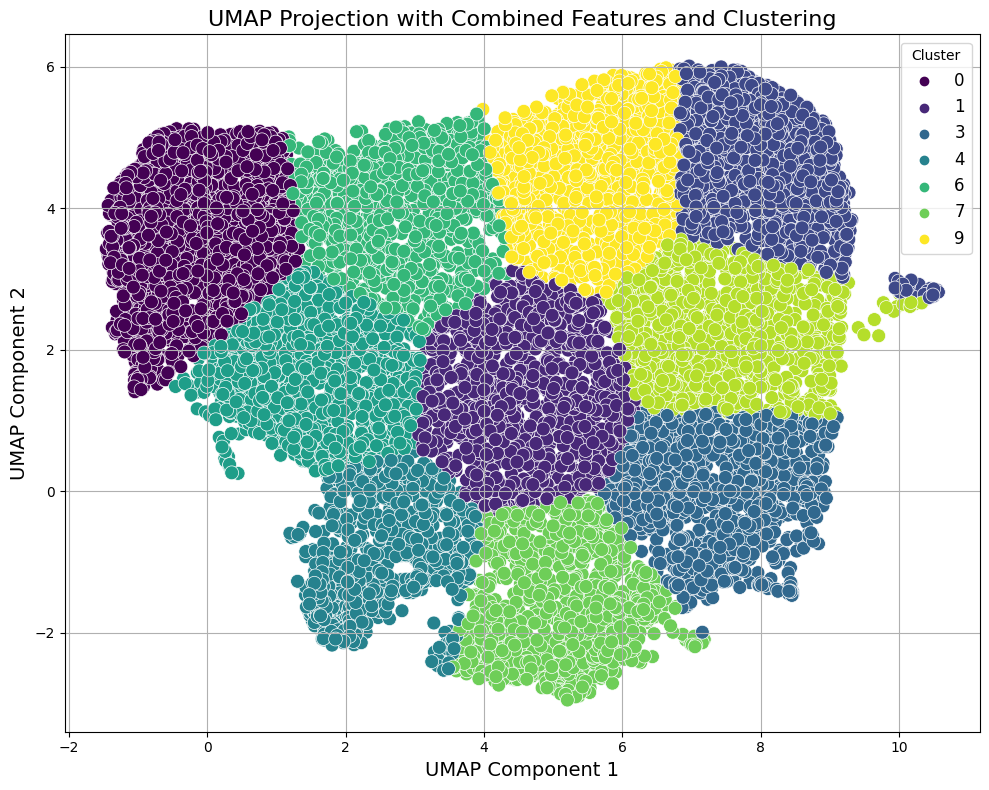

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from umap import UMAP
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import cosine_similarity
import gseapy as gp
import pickle
from sklearn.impute import SimpleImputer

# Load proteomics data
proteomics_metadata = pd.read_csv('AML_proteomics_meta.txt', sep='\t')
quant = pd.read_csv('AML_proteomics_quant.txt', sep='\t', index_col=0)
log2fc_df = pd.read_csv('DEqMS_LC_log2FC_all.txt', sep='\t', index_col=0)
pval_df = pd.read_csv('DEqMS_LC_Pvalues_all.txt', sep='\t', index_col=0)

# Define thresholds for fold change and p-value but apply them optionally if needed
fc_value = 0.5
p_value = 0.01
fc_thres = log2fc_df[log2fc_df.abs() > fc_value].dropna(how='all')
p_thres = pval_df[pval_df < p_value].dropna(how='all')

# To use all proteins, directly use quant matrix without filtering by thresholds
quant_filtered = quant

# Compute correlation matrix for all proteins
correlation_matrix = quant_filtered.T.corr(method='pearson')

# Load GenePT gene embeddings
with open('GenePT_emebdding_v2/GenePT_gene_embedding_ada_text.pickle', 'rb') as f:
    gene_embeddings_ada = pickle.load(f)

with open('GenePT_emebdding_v2/GenePT_gene_protein_embedding_model_3_text.pickle.', 'rb') as f:
    gene_embeddings_protein = pickle.load(f)

# Filter GenePT embeddings for proteins in the quant data
filtered_embeddings = {gene: emb for gene, emb in gene_embeddings_protein.items() if gene in quant.index}

# Convert filtered embeddings to a DataFrame
embedding_df = pd.DataFrame.from_dict(filtered_embeddings, orient='index')

# Compute cosine similarity matrix for GenePT embeddings
genept_similarity_matrix = cosine_similarity(embedding_df)

# Ensure matrices are aligned by index (proteins)
common_proteins = sorted(set(quant_filtered.index) & set(embedding_df.index))

quant_filtered = quant_filtered.loc[common_proteins]
correlation_matrix = correlation_matrix.loc[common_proteins, common_proteins]
embedding_df = embedding_df.loc[common_proteins]

# Combine both similarity matrix (from quant data) and GenePT embeddings as features
combined_features = np.hstack([correlation_matrix.values, embedding_df.values])



# Impute missing values with the mean of each feature
imputer = SimpleImputer(strategy="mean")
combined_features_imputed = imputer.fit_transform(combined_features)

# Dimensionality reduction using PCA on imputed data
pca = PCA(n_components=50)
pca_result = pca.fit_transform(combined_features_imputed)

# Continue with UMAP and clustering
umap_model = UMAP(n_neighbors=20, min_dist=0.2, metric="euclidean")
umap_result = umap_model.fit_transform(pca_result)

# Clustering using K-Means
kmeans = KMeans(n_clusters=10, random_state=42)
clusters = kmeans.fit_predict(umap_result)

# Create a DataFrame for UMAP results and cluster assignments
umap_df = pd.DataFrame(umap_result, columns=["UMAP1", "UMAP2"])
umap_df["Cluster"] = clusters
umap_df["Protein"] = common_proteins

# Visualization: UMAP with K-Means clusters
plt.figure(figsize=(10, 8))
sns.scatterplot(
    data=umap_df,
    x="UMAP1",
    y="UMAP2",
    hue="Cluster",
    palette="viridis",
    s=100,
    edgecolor="w",
    linewidth=0.5,
)
plt.title("UMAP Projection with Combined Features and Clustering", fontsize=16)
plt.xlabel("UMAP Component 1", fontsize=14)
plt.ylabel("UMAP Component 2", fontsize=14)
plt.legend(title="Cluster", fontsize=12)
plt.grid(True)
plt.tight_layout()
plt.show()

In [6]:
import pandas as pd
import numpy as np
import itertools
from sklearn.model_selection import train_test_split

# Load proteomics data (assuming this is already done in your workflow)
proteomics_metadata = pd.read_csv('AML_proteomics_meta.txt', sep='\t')
quant = pd.read_csv('AML_proteomics_quant.txt', sep='\t', index_col=0)
log2fc_df = pd.read_csv('DEqMS_LC_log2FC_all.txt', sep='\t', index_col=0)
pval_df = pd.read_csv('DEqMS_LC_Pvalues_all.txt', sep='\t', index_col=0)

# Filter proteins based on fold change and p-value thresholds
fc_value = 0.5
p_value = 0.01
fc_thres = log2fc_df[log2fc_df.abs() > fc_value].dropna(how='all')
p_thres = pval_df[pval_df < p_value].dropna(how='all')
distinct_proteins = set(fc_thres.index) & set(p_thres.index)

# Filter the quant matrix for distinct proteins
quant_filtered = quant

# Load CORUM data
corum = pd.read_csv('CORUM_dat.txt', sep='\t')  # Adjust the separator as per the actual file

def extract_ppi_from_corum(corum_df, gene_col='subunits.Gene.name.'):
    ppi_pairs = set()
    for proteins in corum_df[gene_col].dropna():
        proteins = proteins.split(';')  # Assuming proteins are separated by semicolons
        proteins = [prot.strip() for prot in proteins]
        for pair in itertools.combinations(proteins, 2):
            ppi_pairs.add(pair)
    return ppi_pairs

# Now call the function with the updated column name
known_ppi = extract_ppi_from_corum(corum)

# Ensure proteins in CORUM are in the quant_filtered dataset
known_ppi = {pair for pair in known_ppi if pair[0] in quant_filtered.index and pair[1] in quant_filtered.index}

print(f"Number of known PPIs: {len(known_ppi)}")

Number of known PPIs: 40791


In [7]:
quant_filtered

,SetA_tmt10plex_127N,SetA_tmt10plex_127C,SetA_tmt10plex_128N,SetA_tmt10plex_128C,SetA_tmt10plex_129N,SetA_tmt10plex_129C,SetA_tmt10plex_130N,SetA_tmt10plex_130C,SetA_tmt10plex_131,SetB_tmt10plex_126,...,SetM_tmt10plex_131,SetN_tmt10plex_126,SetN_tmt10plex_127N,SetN_tmt10plex_127C,SetN_tmt10plex_128C,SetN_tmt10plex_129N,SetN_tmt10plex_129C,SetN_tmt10plex_130N,SetN_tmt10plex_130C,SetN_tmt10plex_131
A1BG,-0.248427,0.342380,-0.422836,0.523159,0.838483,0.104756,0.152693,-0.307978,0.015145,-0.250013,...,0.604403,0.120395,0.276506,-0.224080,-0.193982,0.258954,0.061537,0.370149,0.490885,0.185676
A1CF,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
A2M,-1.204522,-0.329580,-0.680533,0.075529,1.109671,-0.513389,-0.064456,-1.147968,-0.035746,-1.178612,...,0.886675,-0.689876,0.328976,-0.685488,-1.077732,-0.347891,-0.466748,1.296028,1.295298,-0.273764
A2ML1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-1.896183,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
A4GALT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZXDC,-0.058476,-0.008718,-0.107304,0.069906,0.217800,-0.001909,0.806620,0.391783,0.119970,-0.128883,...,0.394077,0.022023,-0.072785,-0.194928,0.002184,-0.014270,-0.008125,0.120091,0.046638,0.061147
ZYG11A,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.094967,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ZYG11B,-0.016762,0.204328,0.067654,-0.034321,0.276813,0.060520,-0.376834,-0.402054,0.241463,-0.156688,...,0.300303,0.007847,-0.106826,0.014899,-0.064751,0.007578,0.218762,-0.054245,-0.184437,-0.000417
ZYX,-0.307382,0.174706,0.187278,0.174434,-0.418368,-0.058776,0.021535,0.108408,0.407019,-0.220356,...,-0.077836,-0.074105,-0.227269,-0.217122,-0.049095,-0.118532,0.250813,-0.563276,0.317140,-0.049294


In [8]:
# Total possible pairs
all_proteins = list(quant_filtered.index)
total_possible_pairs = set(itertools.combinations(sorted(all_proteins), 2))

# Exclude known PPIs to get negative candidates
non_interacting_pairs = list(total_possible_pairs - known_ppi)

# Number of negative samples (e.g., equal to positives)
num_negatives = len(known_ppi)

# Randomly select negative samples
np.random.seed(42)
negative_samples = set()
while len(negative_samples) < num_negatives:
    pair = tuple(np.random.choice(all_proteins, 2, replace=False))
    pair = tuple(sorted(pair))
    if pair not in known_ppi and pair not in negative_samples:
        negative_samples.add(pair)

print(f"Number of negative samples: {len(negative_samples)}")

Number of negative samples: 40791


In [9]:
# Create DataFrame for positive and negative samples
positive_df = pd.DataFrame(list(known_ppi), columns=['Protein1', 'Protein2'])
positive_df['Label'] = 1

negative_df = pd.DataFrame(list(negative_samples), columns=['Protein1', 'Protein2'])
negative_df['Label'] = 0

# Combine and shuffle
ppi_data = pd.concat([positive_df, negative_df], ignore_index=True)
ppi_data = ppi_data.sample(frac=1, random_state=42).reset_index(drop=True)

print(ppi_data.head())
print(ppi_data['Label'].value_counts())

  Protein1 Protein2  Label
0   HNRNPM    SRSF3      1
1    SRSF2    DDX20      1
2    PCBP1    PBRM1      1
3   ABCC12    MZT2B      0
4      SSB     CALR      1
Label
1    40791
0    40791
Name: count, dtype: int64


In [10]:
from sklearn.metrics.pairwise import cosine_similarity

# Assuming 'correlation_matrix' and 'embedding_df' are already defined from your initial code

# Function to compute features for each protein pair
# Function to compute features for each protein pair
def compute_features(row, corr_matrix, embedding_df):
    prot1, prot2 = row['Protein1'], row['Protein2']
    
    # Check if both proteins exist in correlation_matrix and embedding_df
    if prot1 not in corr_matrix.index or prot2 not in corr_matrix.columns:
        corr = np.nan  # Assign NaN if protein is missing
    else:
        corr = corr_matrix.loc[prot1, prot2]

    if prot1 not in embedding_df.index or prot2 not in embedding_df.index:
        cos_sim = np.nan
    else:
        # Cosine similarity of embeddings
        emb1 = embedding_df.loc[prot1].values.reshape(1, -1)
        emb2 = embedding_df.loc[prot2].values.reshape(1, -1)
        cos_sim = cosine_similarity(emb1, emb2)[0][0]
    
    if prot1 not in quant_filtered.index or prot2 not in quant_filtered.index:
        euclidean_dist = np.nan
    else:
        # Euclidean distance of quant profiles
        quant1 = quant_filtered.loc[prot1].values
        quant2 = quant_filtered.loc[prot2].values
        euclidean_dist = np.linalg.norm(quant1 - quant2)

    return pd.Series({'Correlation': corr, 'Cosine_Similarity': cos_sim, 'Euclidean_Distance': euclidean_dist})
# Filter PPI data to include only rows where both proteins are present in the correlation_matrix and embedding_df
filtered_ppi_data = ppi_data[
    (ppi_data['Protein1'].isin(correlation_matrix.index)) & 
    (ppi_data['Protein2'].isin(correlation_matrix.columns)) &
    (ppi_data['Protein1'].isin(embedding_df.index)) &
    (ppi_data['Protein2'].isin(embedding_df.index))
]

# Apply feature computation on the filtered data
features = filtered_ppi_data.apply(compute_features, axis=1, args=(correlation_matrix, embedding_df))
feature_df = pd.concat([filtered_ppi_data, features], axis=1)

print(feature_df.head())

  Protein1 Protein2  Label  Correlation  Cosine_Similarity  Euclidean_Distance
0   HNRNPM    SRSF3      1     0.725034           0.577358            1.393223
1    SRSF2    DDX20      1     0.017438           0.598830            3.300664
2    PCBP1    PBRM1      1     0.232756           0.484024            2.791214
3   ABCC12    MZT2B      0    -0.853687           0.405914                 NaN
4      SSB     CALR      1    -0.231098           0.453899            6.541090


In [29]:
feature_df

,Protein1,Protein2,Label,Correlation,Cosine_Similarity,Euclidean_Distance
0,HNRNPM,SRSF3,1,0.725034,0.577358,1.393223
1,SRSF2,DDX20,1,0.017438,0.598830,3.300664
2,PCBP1,PBRM1,1,0.232756,0.484024,2.791214
3,ABCC12,MZT2B,0,-0.853687,0.405914,NaN
4,SSB,CALR,1,-0.231098,0.453899,6.541090
...,...,...,...,...,...,...
81577,HNRNPA0,DDX23,1,0.656340,0.545318,2.168590
81578,MANBA,OR4D6,0,0.021987,0.348719,NaN
81579,ACADS,XPO6,0,-0.074919,0.299755,4.598817
81580,ILF2,PRPF19,1,0.783548,0.484022,1.431077


In [11]:
from sklearn.model_selection import train_test_split

# Features and target
X = feature_df[['Correlation', 'Cosine_Similarity', 'Euclidean_Distance']]
y = feature_df['Label']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Training samples: {X_train.shape[0]}")
print(f"Testing samples: {X_test.shape[0]}")

Training samples: 64195
Testing samples: 16049


In [12]:
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Initialize models
rf_model = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')
xgb_model = XGBClassifier(n_estimators=100, use_label_encoder=False, eval_metric='logloss', random_state=42)

# Train Random Forest
rf_model.fit(X_train, y_train)

# Train XGBoost
xgb_model.fit(X_train, y_train)

/Users/justinseby/Library/Python/3.9/lib/python/site-packages/xgboost/core.py:158: UserWarning: [12:12:05] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=100,
              n_jobs=None, num_parallel_tree=None, random_state=42, ...)

--- Random Forest Evaluation ---
Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.91      0.88      7980
           1       0.90      0.85      0.88      8069

    accuracy                           0.88     16049
   macro avg       0.88      0.88      0.88     16049
weighted avg       0.88      0.88      0.88     16049

ROC-AUC: 0.9421


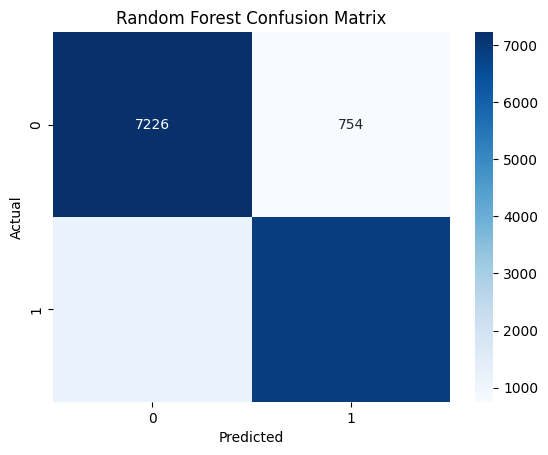

--- XGBoost Evaluation ---
Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.91      0.89      7980
           1       0.91      0.85      0.88      8069

    accuracy                           0.88     16049
   macro avg       0.89      0.88      0.88     16049
weighted avg       0.89      0.88      0.88     16049

ROC-AUC: 0.9477


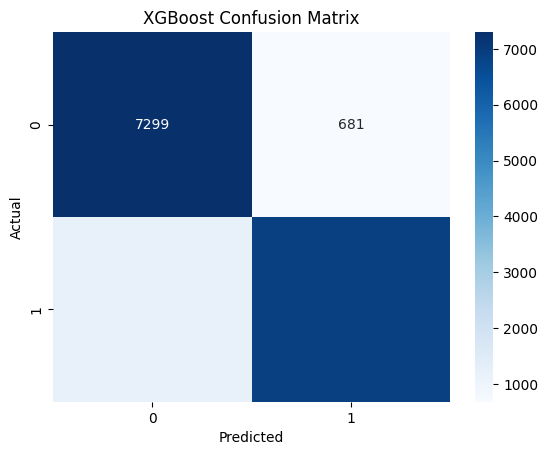

In [13]:
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix

# Function to evaluate models
def evaluate_model(model, X_test, y_test, model_name='Model'):
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]
    
    print(f"--- {model_name} Evaluation ---")
    print("Classification Report:")
    print(classification_report(y_test, y_pred))
    
    roc_auc = roc_auc_score(y_test, y_proba)
    print(f"ROC-AUC: {roc_auc:.4f}")
    
    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'{model_name} Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

# Evaluate Random Forest
evaluate_model(rf_model, X_test, y_test, model_name='Random Forest')

# Evaluate XGBoost
evaluate_model(xgb_model, X_test, y_test, model_name='XGBoost')

Best Parameters for Random Forest: {'max_depth': 10, 'min_samples_split': 5, 'n_estimators': 200}
Best ROC-AUC: 0.9480817767398649
--- Best Random Forest Evaluation ---
Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.92      0.89      7980
           1       0.91      0.85      0.88      8069

    accuracy                           0.88     16049
   macro avg       0.89      0.89      0.88     16049
weighted avg       0.89      0.88      0.88     16049

ROC-AUC: 0.9486


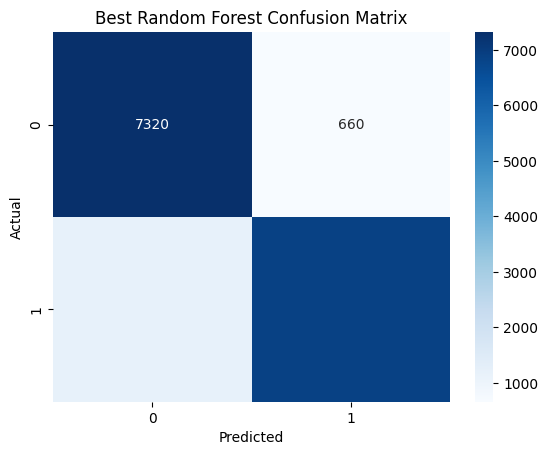

In [14]:
from sklearn.model_selection import GridSearchCV

param_grid_rf = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
}

grid_rf = GridSearchCV(
    estimator=RandomForestClassifier(random_state=42, class_weight='balanced'),
    param_grid=param_grid_rf,
    cv=3,
    scoring='roc_auc',
    n_jobs=-1
)

grid_rf.fit(X_train, y_train)

print("Best Parameters for Random Forest:", grid_rf.best_params_)
print("Best ROC-AUC:", grid_rf.best_score_)

# Best estimator
best_rf = grid_rf.best_estimator_

# Evaluate the best Random Forest
evaluate_model(best_rf, X_test, y_test, model_name='Best Random Forest')


Missing values in features:
Correlation            1460
Cosine_Similarity         0
Euclidean_Distance    23174
dtype: int64
Fitting 5 folds for each of 108 candidates, totalling 540 fits

Best parameters: {'classifier__l2_regularization': 1.0, 'classifier__learning_rate': 0.1, 'classifier__max_depth': 5, 'classifier__max_iter': 200, 'classifier__min_samples_leaf': 30}
Best cross-validation score: 0.9483764680412305

--- Tuned HistGradient Boosting Evaluation ---

Training Set Performance:
              precision    recall  f1-score   support

           0       0.86      0.92      0.89     31922
           1       0.92      0.85      0.89     32273

    accuracy                           0.89     64195
   macro avg       0.89      0.89      0.89     64195
weighted avg       0.89      0.89      0.89     64195

Training ROC-AUC: 0.9510

Test Set Performance:
              precision    recall  f1-score   support

           0       0.86      0.92      0.89      7980
           1       0

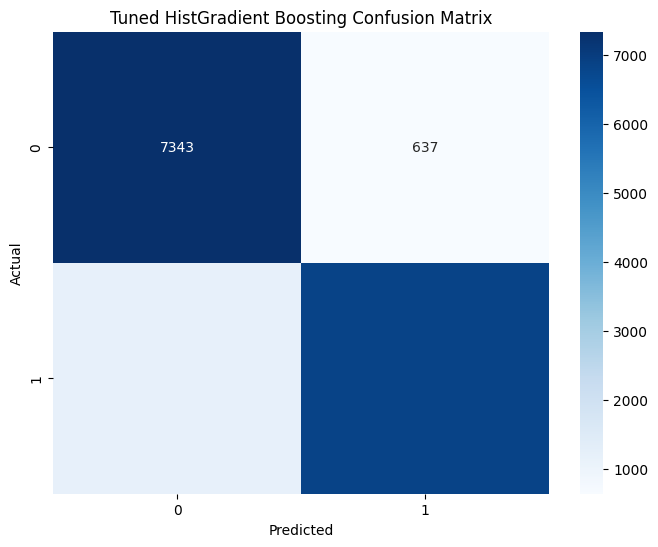


Feature Importance:
Cosine_Similarity: 0.1678 ± 0.0027
Euclidean_Distance: 0.1595 ± 0.0020
Correlation: 0.0131 ± 0.0014


In [15]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.ensemble import GradientBoostingClassifier, HistGradientBoostingClassifier
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
import numpy as np

# Check for missing values
print("\nMissing values in features:")
print(X.isna().sum())

# Create a pipeline with imputer, scaler, and model
pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler()),
    ('classifier', HistGradientBoostingClassifier(random_state=42))
])

# Define parameter grid for GridSearchCV
param_grid = {
    'classifier__max_iter': [100, 200],
    'classifier__learning_rate': [0.01, 0.1, 0.3],
    'classifier__max_depth': [3, 4, 5],
    'classifier__min_samples_leaf': [20, 30],
    'classifier__l2_regularization': [0, 1.0, 2.0]
}

# Create GridSearchCV object
grid_search = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    cv=5,
    scoring='roc_auc',
    n_jobs=-1,
    verbose=1
)

# Fit the model
grid_search.fit(X_train, y_train)

# Print best parameters and score
print("\nBest parameters:", grid_search.best_params_)
print("Best cross-validation score:", grid_search.best_score_)

# Get the best model
best_model = grid_search.best_estimator_

# Evaluate the model
def evaluate_model_extended(model, X_train, X_test, y_train, y_test, model_name='Model'):
    # Training predictions
    train_pred = model.predict(X_train)
    train_proba = model.predict_proba(X_train)[:, 1]
    
    # Test predictions
    test_pred = model.predict(X_test)
    test_proba = model.predict_proba(X_test)[:, 1]
    
    # Cross-validation scores
    cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='roc_auc')
    
    print(f"\n--- {model_name} Evaluation ---")
    print("\nTraining Set Performance:")
    print(classification_report(y_train, train_pred))
    print(f"Training ROC-AUC: {roc_auc_score(y_train, train_proba):.4f}")
    
    print("\nTest Set Performance:")
    print(classification_report(y_test, test_pred))
    print(f"Test ROC-AUC: {roc_auc_score(y_test, test_proba):.4f}")
    
    print("\nCross-validation ROC-AUC scores:", cv_scores)
    print(f"Mean CV ROC-AUC: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")
    
    # Confusion Matrix
    plt.figure(figsize=(8, 6))
    cm = confusion_matrix(y_test, test_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'{model_name} Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

# Evaluate the best model
evaluate_model_extended(best_model, X_train, X_test, y_train, y_test, 
                       model_name='Tuned HistGradient Boosting')

# Function to analyze feature importance (using permutation importance)
from sklearn.inspection import permutation_importance

def analyze_feature_importance(model, X, y, feature_names):
    # Calculate permutation importance
    result = permutation_importance(
        model, X, y,
        n_repeats=10,
        random_state=42
    )
    
    # Create importance dictionary
    importance_dict = {
        name: {'importance': imp, 'std': std}
        for name, imp, std in zip(
            feature_names,
            result.importances_mean,
            result.importances_std
        )
    }
    
    # Sort and print feature importance
    print("\nFeature Importance:")
    for name, stats in sorted(
        importance_dict.items(),
        key=lambda x: x[1]['importance'],
        reverse=True
    ):
        print(f"{name}: {stats['importance']:.4f} ± {stats['std']:.4f}")

# Analyze feature importance
analyze_feature_importance(best_model, X_test, y_test, X.columns)

In [18]:
!pip install catboost

/var/folders/mx/537v7g2946xclrs7ttjwd3vh0000gn/T/ipykernel_22556/2469772599.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['Corr_Cos'] = X['Correlation'] * X['Cosine_Similarity']
/var/folders/mx/537v7g2946xclrs7ttjwd3vh0000gn/T/ipykernel_22556/2469772599.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['Corr_Euc'] = X['Correlation'] * X['Euclidean_Distance']


Training MLP model...
Fitting 5 folds for each of 36 candidates, totalling 180 fits
Iteration 1, loss = 0.39555040
Validation score: 0.873832
Iteration 2, loss = 0.30946525
Validation score: 0.881036
Iteration 3, loss = 0.30018242
Validation score: 0.882593
Iteration 4, loss = 0.29549031
Validation score: 0.883372
Iteration 5, loss = 0.29260421
Validation score: 0.885125
Iteration 6, loss = 0.29101055
Validation score: 0.886877
Iteration 7, loss = 0.28959029
Validation score: 0.886488
Iteration 8, loss = 0.28887766
Validation score: 0.885319
Iteration 9, loss = 0.28822944
Validation score: 0.888240
Iteration 10, loss = 0.28780173
Validation score: 0.888629
Iteration 11, loss = 0.28792798
Validation score: 0.886682
Iteration 12, loss = 0.28734532
Validation score: 0.889213
Iteration 13, loss = 0.28671402
Validation score: 0.889019
Iteration 14, loss = 0.28656132
Validation score: 0.889213
Iteration 15, loss = 0.28636143
Validation score: 0.888824
Iteration 16, loss = 0.28617185
Validati

NameError: name 'roc_curve' is not defined

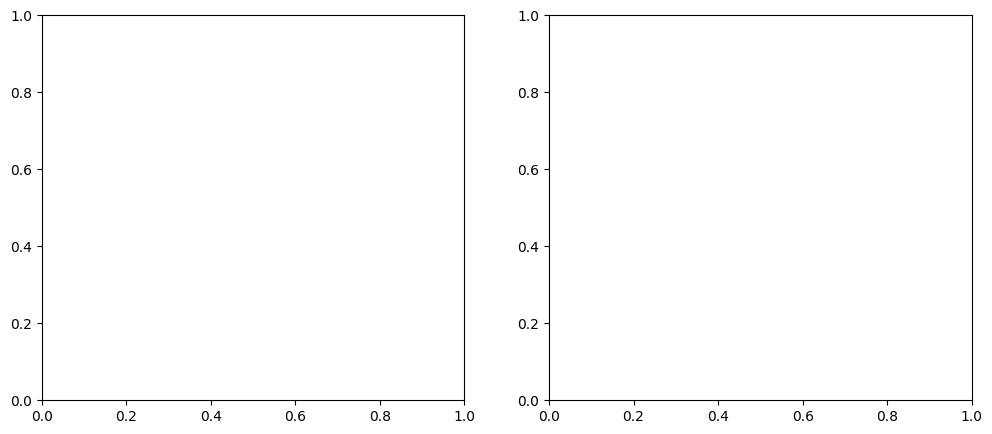

In [17]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, roc_auc_score, precision_recall_curve, average_precision_score
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt
import seaborn as sns

class MLPPredictor:
    def __init__(self, random_state=42):
        self.random_state = random_state
        self.pipeline = Pipeline([
            ('imputer', SimpleImputer(strategy='median')),
            ('scaler', StandardScaler()),
            ('mlp', MLPClassifier(
                random_state=random_state,
                early_stopping=True,
                validation_fraction=0.1,
                max_iter=1000,
                verbose=True
            ))
        ])
        
        # Define hyperparameter grid for tuning
        self.param_grid = {
            'mlp__hidden_layer_sizes': [
                (100,), (100, 50), (100, 50, 25)
            ],
            'mlp__alpha': [0.0001, 0.001, 0.01],
            'mlp__learning_rate_init': [0.001, 0.01],
            'mlp__activation': ['relu', 'tanh']
        }
        
    def prepare_data(self, feature_df):
        """
        Prepare the data for training/testing
        """
        # Extract base features
        X = feature_df[['Correlation', 'Cosine_Similarity', 'Euclidean_Distance']]
        y = feature_df['Label']
        
        # Add interaction features
        X['Corr_Cos'] = X['Correlation'] * X['Cosine_Similarity']
        X['Corr_Euc'] = X['Correlation'] * X['Euclidean_Distance']
        X['Cos_Euc'] = X['Cosine_Similarity'] * X['Euclidean_Distance']
        
        # Add polynomial features for Correlation
        X['Correlation_Squared'] = X['Correlation'] ** 2
        
        return X, y
    
    def tune_hyperparameters(self, X_train, y_train):
        """
        Perform grid search to find optimal hyperparameters
        """
        grid_search = GridSearchCV(
            self.pipeline,
            self.param_grid,
            cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=self.random_state),
            scoring='roc_auc',
            n_jobs=-1,
            verbose=2
        )
        
        grid_search.fit(X_train, y_train)
        
        print("Best parameters:", grid_search.best_params_)
        print("Best cross-validation score:", grid_search.best_score_)
        
        return grid_search.best_estimator_
    
    def train_evaluate(self, X, y, test_size=0.2):
        """
        Train and evaluate the model
        """
        # Split the data
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=test_size, random_state=self.random_state, stratify=y
        )
        
        print("Training MLP model...")
        # Tune hyperparameters and get best model
        self.model = self.tune_hyperparameters(X_train, y_train)
        
        # Get predictions
        y_pred = self.model.predict(X_test)
        y_prob = self.model.predict_proba(X_test)[:, 1]
        
        # Calculate metrics
        roc_auc = roc_auc_score(y_test, y_prob)
        avg_precision = average_precision_score(y_test, y_prob)
        
        # Print results
        print("\nModel Evaluation:")
        print(f"ROC-AUC Score: {roc_auc:.3f}")
        print(f"Average Precision Score: {avg_precision:.3f}")
        print("\nClassification Report:")
        print(classification_report(y_test, y_pred))
        
        # Plot results
        self.plot_evaluation_curves(y_test, y_prob)
        self.plot_confusion_matrix(y_test, y_pred)
        
        return self.model
    
    def plot_evaluation_curves(self, y_test, y_prob):
        """
        Plot ROC and Precision-Recall curves
        """
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
        
        # ROC curve
        fpr, tpr, _ = roc_curve(y_test, y_prob)
        roc_auc = auc(fpr, tpr)
        ax1.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.2f})')
        ax1.plot([0, 1], [0, 1], 'k--')
        ax1.set_xlabel('False Positive Rate')
        ax1.set_ylabel('True Positive Rate')
        ax1.set_title('ROC Curve')
        ax1.legend()
        
        # Precision-Recall curve
        precision, recall, _ = precision_recall_curve(y_test, y_prob)
        avg_precision = average_precision_score(y_test, y_prob)
        ax2.plot(recall, precision, label=f'PR curve (AP = {avg_precision:.2f})')
        ax2.set_xlabel('Recall')
        ax2.set_ylabel('Precision')
        ax2.set_title('Precision-Recall Curve')
        ax2.legend()
        
        plt.tight_layout()
        plt.show()
    
    def plot_confusion_matrix(self, y_test, y_pred):
        """
        Plot confusion matrix
        """
        cm = confusion_matrix(y_test, y_pred)
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
        plt.title('Confusion Matrix')
        plt.xlabel('Predicted')
        plt.ylabel('Actual')
        plt.show()
    
    def predict(self, X_new):
        """
        Make predictions on new data
        """
        if not hasattr(self, 'model'):
            raise ValueError("Model has not been trained yet. Call train_evaluate first.")
        return self.model.predict_proba(X_new)[:, 1]

# Usage example:
def main():
    # Create predictor instance
    predictor = MLPPredictor()
    
    # Prepare the data (assuming feature_df is your prepared dataset)
    X, y = predictor.prepare_data(feature_df)
    
    # Train and evaluate the model
    model = predictor.train_evaluate(X, y)
    
    # Optional: Make predictions on new data
    # predictions = predictor.predict(X_new)

if __name__ == "__main__":
    main()

Number of nodes: 3603
Number of edges: 40337
Average degree: 22.390785456563975


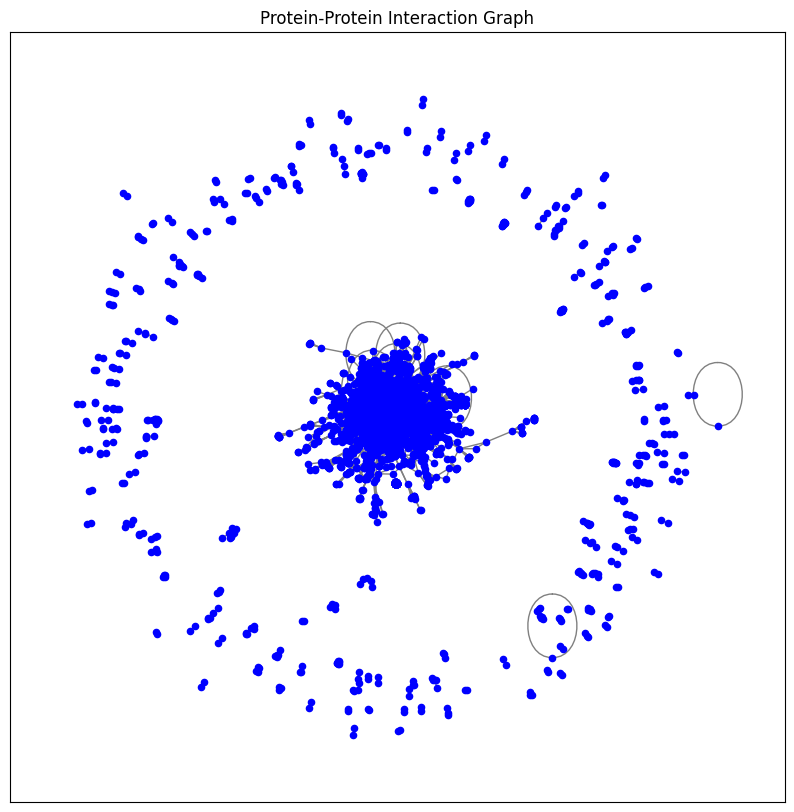

[CV] END lgbm__colsample_bytree=1.0, lgbm__learning_rate=0.05, lgbm__max_depth=5, lgbm__min_child_samples=30, lgbm__n_estimators=300, lgbm__num_leaves=63, lgbm__subsample=0.9; total time=   0.0s
[CV] END lgbm__colsample_bytree=1.0, lgbm__learning_rate=0.05, lgbm__max_depth=5, lgbm__min_child_samples=30, lgbm__n_estimators=300, lgbm__num_leaves=127, lgbm__subsample=1.0; total time=   0.0s
[CV] END lgbm__colsample_bytree=1.0, lgbm__learning_rate=0.05, lgbm__max_depth=5, lgbm__min_child_samples=50, lgbm__n_estimators=200, lgbm__num_leaves=63, lgbm__subsample=1.0; total time=   0.0s
[CV] END lgbm__colsample_bytree=1.0, lgbm__learning_rate=0.05, lgbm__max_depth=5, lgbm__min_child_samples=50, lgbm__n_estimators=300, lgbm__num_leaves=63, lgbm__subsample=1.0; total time=   0.0s
[CV] END lgbm__colsample_bytree=1.0, lgbm__learning_rate=0.05, lgbm__max_depth=7, lgbm__min_child_samples=20, lgbm__n_estimators=100, lgbm__num_leaves=63, lgbm__subsample=0.8; total time=   0.0s
[CV] END lgbm__colsample

In [21]:
import networkx as nx
import matplotlib.pyplot as plt

# Create a graph
G = nx.Graph()

# Add nodes and edges from the predicted positive interactions
for _, row in feature_df.iterrows():
    if row['Label'] == 1:  # Only include  positives (interacting pairs)
        G.add_edge(row['Protein1'], row['Protein2'])

# Basic Graph Information
print("Number of nodes:", G.number_of_nodes())
print("Number of edges:", G.number_of_edges())
print("Average degree:", sum(dict(G.degree()).values()) / G.number_of_nodes())

# Plot the PPI graph
plt.figure(figsize=(10, 10))
pos = nx.spring_layout(G, seed=42)  # Positioning for visualization
nx.draw_networkx(G, pos, node_size=20, node_color='blue', edge_color='gray', with_labels=False)
plt.title("Protein-Protein Interaction Graph")
plt.show()

### Just with the similarity

In [22]:
from sklearn.metrics.pairwise import cosine_similarity

# Assuming 'correlation_matrix' and 'embedding_df' are already defined from your initial code

# Function to compute features for each protein pair
# Function to compute features for each protein pair
def compute_features(row, corr_matrix, embedding_df):
    prot1, prot2 = row['Protein1'], row['Protein2']
    
    # Check if both proteins exist in correlation_matrix and embedding_df
    if prot1 not in corr_matrix.index or prot2 not in corr_matrix.columns:
        corr = np.nan  # Assign NaN if protein is missing
    else:
        corr = corr_matrix.loc[prot1, prot2]

    if prot1 not in embedding_df.index or prot2 not in embedding_df.index:
        cos_sim = np.nan
    else:
        # Cosine similarity of embeddings
        emb1 = embedding_df.loc[prot1].values.reshape(1, -1)
        emb2 = embedding_df.loc[prot2].values.reshape(1, -1)
        cos_sim = cosine_similarity(emb1, emb2)[0][0]
    
    if prot1 not in quant_filtered.index or prot2 not in quant_filtered.index:
        euclidean_dist = np.nan
    else:
        # Euclidean distance of quant profiles
        quant1 = quant_filtered.loc[prot1].values
        quant2 = quant_filtered.loc[prot2].values
        euclidean_dist = np.linalg.norm(quant1 - quant2)

    return pd.Series({'Correlation': corr, 'Cosine_Similarity': cos_sim, 'Euclidean_Distance': euclidean_dist})
# Filter PPI data to include only rows where both proteins are present in the correlation_matrix and embedding_df
filtered_ppi_data = ppi_data[
    (ppi_data['Protein1'].isin(correlation_matrix.index)) & 
    (ppi_data['Protein2'].isin(correlation_matrix.columns)) &
    (ppi_data['Protein1'].isin(embedding_df.index)) &
    (ppi_data['Protein2'].isin(embedding_df.index))
]

# Apply feature computation on the filtered data
features = filtered_ppi_data.apply(compute_features, axis=1, args=(correlation_matrix, embedding_df))
feature_df = pd.concat([filtered_ppi_data, features], axis=1)

print(feature_df.head())

  Protein1 Protein2  Label  Correlation  Cosine_Similarity  Euclidean_Distance
0   HNRNPM    SRSF3      1     0.725034           0.577358            1.393223
1    SRSF2    DDX20      1     0.017438           0.598830            3.300664
2    PCBP1    PBRM1      1     0.232756           0.484024            2.791214
3   ABCC12    MZT2B      0    -0.853687           0.405914                 NaN
4      SSB     CALR      1    -0.231098           0.453899            6.541090


In [23]:
from sklearn.model_selection import train_test_split

# Features and target
X = feature_df[['Correlation']]
y = feature_df['Label']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Training samples: {X_train.shape[0]}")
print(f"Testing samples: {X_test.shape[0]}")

Training samples: 64195
Testing samples: 16049


In [24]:
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Initialize models
rf_model = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')
xgb_model = XGBClassifier(n_estimators=100, use_label_encoder=False, eval_metric='logloss', random_state=42)

# Train Random Forest
rf_model.fit(X_train, y_train)

# Train XGBoost
xgb_model.fit(X_train, y_train)

/Users/justinseby/Library/Python/3.9/lib/python/site-packages/xgboost/core.py:158: UserWarning: [12:59:31] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=100,
              n_jobs=None, num_parallel_tree=None, random_state=42, ...)

--- Random Forest Evaluation ---
Classification Report:
              precision    recall  f1-score   support

           0       0.67      0.67      0.67      7980
           1       0.68      0.68      0.68      8069

    accuracy                           0.68     16049
   macro avg       0.68      0.68      0.68     16049
weighted avg       0.68      0.68      0.68     16049

ROC-AUC: 0.7633


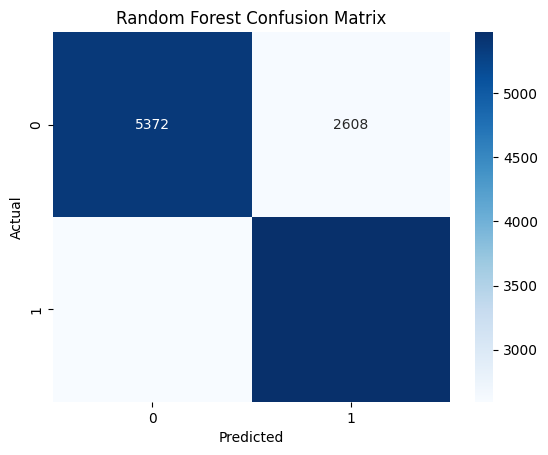

--- XGBoost Evaluation ---
Classification Report:
              precision    recall  f1-score   support

           0       0.73      0.83      0.78      7980
           1       0.80      0.69      0.74      8069

    accuracy                           0.76     16049
   macro avg       0.77      0.76      0.76     16049
weighted avg       0.77      0.76      0.76     16049

ROC-AUC: 0.8323


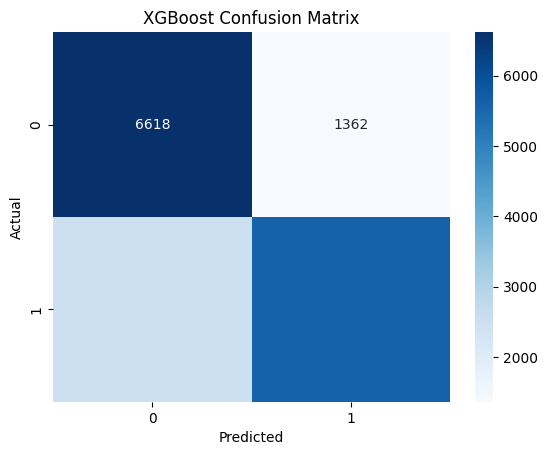

In [25]:
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix

# Function to evaluate models
def evaluate_model(model, X_test, y_test, model_name='Model'):
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]
    
    print(f"--- {model_name} Evaluation ---")
    print("Classification Report:")
    print(classification_report(y_test, y_pred))
    
    roc_auc = roc_auc_score(y_test, y_proba)
    print(f"ROC-AUC: {roc_auc:.4f}")
    
    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'{model_name} Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

# Evaluate Random Forest
evaluate_model(rf_model, X_test, y_test, model_name='Random Forest')

# Evaluate XGBoost
evaluate_model(xgb_model, X_test, y_test, model_name='XGBoost')

In [26]:
from sklearn.model_selection import train_test_split

# Features and target
X = feature_df[['Cosine_Similarity']]
y = feature_df['Label']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Training samples: {X_train.shape[0]}")
print(f"Testing samples: {X_test.shape[0]}")

Training samples: 64195
Testing samples: 16049


In [27]:
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Initialize models
rf_model = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')
xgb_model = XGBClassifier(n_estimators=100, use_label_encoder=False, eval_metric='logloss', random_state=42)

# Train Random Forest
rf_model.fit(X_train, y_train)

# Train XGBoost
xgb_model.fit(X_train, y_train)

/Users/justinseby/Library/Python/3.9/lib/python/site-packages/xgboost/core.py:158: UserWarning: [13:01:10] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=100,
              n_jobs=None, num_parallel_tree=None, random_state=42, ...)

--- Random Forest Evaluation ---
Classification Report:
              precision    recall  f1-score   support

           0       0.75      0.75      0.75      7980
           1       0.75      0.75      0.75      8069

    accuracy                           0.75     16049
   macro avg       0.75      0.75      0.75     16049
weighted avg       0.75      0.75      0.75     16049

ROC-AUC: 0.8470


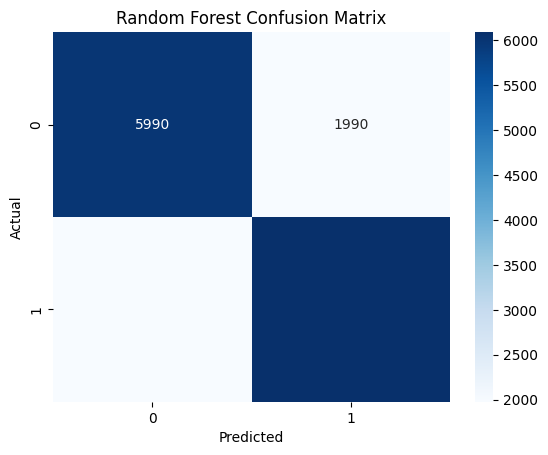

--- XGBoost Evaluation ---
Classification Report:
              precision    recall  f1-score   support

           0       0.79      0.86      0.83      7980
           1       0.85      0.78      0.81      8069

    accuracy                           0.82     16049
   macro avg       0.82      0.82      0.82     16049
weighted avg       0.82      0.82      0.82     16049

ROC-AUC: 0.8942


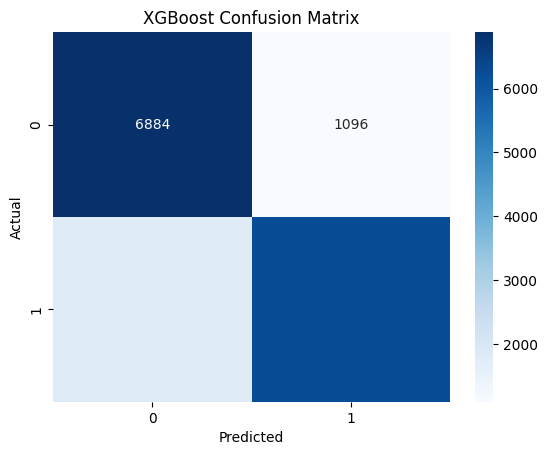

In [28]:
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix

# Function to evaluate models
def evaluate_model(model, X_test, y_test, model_name='Model'):
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]
    
    print(f"--- {model_name} Evaluation ---")
    print("Classification Report:")
    print(classification_report(y_test, y_pred))
    
    roc_auc = roc_auc_score(y_test, y_proba)
    print(f"ROC-AUC: {roc_auc:.4f}")
    
    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'{model_name} Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

# Evaluate Random Forest
evaluate_model(rf_model, X_test, y_test, model_name='Random Forest')

# Evaluate XGBoost
evaluate_model(xgb_model, X_test, y_test, model_name='XGBoost')

In [ ]:
LANGCHAIN_API_KEY = "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"
